In [1]:
import pandas as pd
import numpy as np
def summarize_dataset(path=None, date_cols=None, group_cols=None):
    df = pd.read_csv(path, sep=None, e_ngine='python')

    summary = {}

    # 2. Informations de base
    summary["Rows"] = df.shape[0]
    summary["Columns"] = df.shape[1]
    # Calcul plus précis des données manquantes
    summary["Missing (%)"] = round(df.isna().mean().mean() * 100, 2)

    # 3. Gestion intelligente des dates
    if date_cols:
        try:
            # Si on donne une liste de colonnes (ex: ['Date', 'Time']), on les combine
            if isinstance(date_cols, list):
                date_series = df[date_cols].astype(str).agg(' '.join, axis=1)
            else:
                date_series = df[date_cols]
                
            temp_dt = pd.to_datetime(date_series, errors="coerce")
            summary["Start date"] = temp_dt.min()
            summary["End date"] = temp_dt.max()
        except Exception:
            summary["Start date"] = "N/A"
            summary["End date"] = "N/A"
    else:
        summary["Start date"] = "N/A"
        summary["End date"] = "N/A"

    # 4. Diversité (Unique Values) - Corrigé pour inclure TOUTES les colonnes
    diversity_info = {}
    for col in df.columns:
        diversity_info[col] = df[col].nunique()

    # 5. Fréquence de groupe (Optionnel)
    freq = None
    if group_cols:
        try:
            freq = df.groupby(group_cols).size().mean()
        except Exception:
            freq = "N/A"

    return {
        "Summary": pd.DataFrame(summary, index=[0]),
        "Column types": df.dtypes,
        "Diversity": pd.Series(diversity_info), # Renommé pour être plus clair
        "Avg group frequency": freq,
    }

In [2]:
def clean_nans(df, strategy="drop", fill_value=None):
    
    df_cleaned = df.copy()
    initial_shape = df_cleaned.shape[0]
    
    # 1. Missing analysis
    missing_count = df_cleaned.isna().sum().sum()
    print(f"Missing values found : {missing_count}")
    
    if missing_count == 0:
        return df_cleaned

    # 2. Strategy application
    if strategy == "drop":
        df_cleaned = df_cleaned.dropna()
    elif strategy == "mean":
        df_cleaned = df_cleaned.fillna(df_cleaned.mean(numeric_only=True))
    elif strategy == "median":
        df_cleaned = df_cleaned.fillna(df_cleaned.median(numeric_only=True))
    elif strategy == "ffill":
        df_cleaned = df_cleaned.fillna(method='ffill')
    
    final_shape = df_cleaned.shape[0]
    print(f"cleaning done. Deleted lines : {initial_shape - final_shape}")
    
    return df_cleaned

In [3]:
def add_physical_features(df):
    df_phys = df.copy()
    
    df_phys['Global_active_power']= df_phys['Sub_metering_1'] + df_phys['Sub_metering_2'] + df_phys['Sub_metering_3'] + df_phys['sub_metering_4']
    df_phys['Apparent_Power'] = np.sqrt(df_phys['Global_active_power']**2 + df_phys['Global_reactive_power']**2)
    df_phys['Equivalent_Resistance'] = df_phys['Voltage'] / (df_phys['Global_intensity'] + 1e-6)
    df_phys['Admittance'] = df_phys['Global_intensity'] / (df_phys['Voltage'] + 1e-6)
    return df_phys

In [7]:
import numpy as np
import pandas as pd

def extract_features(df, date_col_name, target_col_name, lags=[1, 60, 1440, 10080], window=[60, 1440, 10080]):
    df_feat = df.copy()

    cols_to_remove = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'sub_metering_4']
    df_feat = df_feat.drop(columns=[c for c in cols_to_remove if c in df_feat.columns])

    df_feat[date_col_name] = pd.to_datetime(df_feat[date_col_name], dayfirst=True, errors='coerce')
    df_feat[target_col_name] = pd.to_numeric(df_feat[target_col_name], errors='coerce')
    df_feat = df_feat.dropna(subset=[date_col_name, target_col_name])

    df_feat['hour'] = df_feat[date_col_name].dt.hour
    df_feat['day_of_week'] = df_feat[date_col_name].dt.dayofweek
    df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat['hour'] / 24)
    df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat['hour'] / 24)


    for l in lags:
        df_feat[f'lag_{l}'] = df_feat[target_col_name].shift(l)

    for i in window:
        rolling = df_feat[target_col_name].rolling(window=i)
        df_feat[f'rolling_mean_{i}'] = rolling.mean()
        df_feat[f'rolling_min_{i}'] = rolling.min()
        df_feat[f'rolling_max_{i}'] = rolling.max()

    df_clean = df_feat.dropna().reset_index(drop=True)

    # 6. Séparation
    y = df_clean[target_col_name] # La cible alignée
    
    cols_a_retirer = [
        date_col_name, 
        target_col_name, 
        'Global_intensity', 
        'Global_reactive_power',
        'hour'
    ]
    X = df_clean.drop(columns=[c for c in cols_a_retirer if c in df_clean.columns])
    
    return X, y

In [9]:
from sklearn.preprocessing import MinMaxScaler

def normalize_features(df):
    df_scaled = df.copy()
    cols_to_scale = df_scaled.select_dtypes(include=['float64', 'int64', 'int32']).columns
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])
    
    return df_scaled, scaler

In [11]:
def split_data(X, y, split_ratio=0.8):
    split_index = int(len(X) * split_ratio)

    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    return X_train, X_test, y_train, y_test

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

def metrics(y_test, predictions):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    print(f"📊 Modele Performance :")
    print(f"MAE  (Mean absolute error) : {mae:.4f}")
    print(f"MSE                  : {mse:.4f}")
    print(f"RMSE (Root of the squared error) : {rmse:.4f}")
    print(f"R² Score (Precision) : {r2:.4f} ({r2*100:.2f}%)")

In [15]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, title="Real vs Prediction Comparison"):
    plt.figure(figsize=(15, 6))
    
    # On prend un échantillon pour que le graphique soit lisible
    plt.plot(y_true.values[:200], label="Real", color="blue", linewidth=2)
    plt.plot(y_pred[:200], label="Predicted", color="red", linestyle="--", linewidth=2)
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("CNormalized Consumption")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [16]:
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=50, color='purple', alpha=0.7)
    plt.axvline(x=0, color='black', linestyle='-')
    plt.title("Errors Destribution (Residues)")
    plt.xlabel("Discrepancy between Actual and Predicted")
    plt.ylabel("Frequency")
    plt.show()

In [19]:
def plot_feature_importance(model, X_train):
    importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
    plt.title("Quelles variables influencent le plus la prédiction ?")
    plt.xlabel("Niveau d'importance")
    plt.show()

In [21]:
def plot_lr_weights(model, X_train):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Pour la Régression Linéaire, on utilise .coef_ au lieu de .feature_importances_
    importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Weight': model.coef_
    })
    
    # On ajoute une colonne pour l'importance absolue (la force de l'influence)
    importance['Absolute_Weight'] = np.abs(importance['Weight'])
    importance = importance.sort_values(by='Absolute_Weight', ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Weight'], color='orange')
    plt.title("Coefficients de la Régression Linéaire")
    plt.xlabel("Valeur du Coefficient (Poids)")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df, i, name):
    plt.figure(figsize=(15, 10))
    cor = df.corr()
    sns.heatmap(cor, annot=False, cmap='coolwarm', center=0)
    plt.title(f"Correlation Matrix - {name}")
    plt.savefig(f"{i}_{name}_correlation.png", dpi=300, bbox_inches='tight')
    plt.show()

In [25]:
def filter_high_correlation(df, threshold=0.9):
    # 1. Calculer la matrice de corrélation en valeur absolue
    corr_matrix = df.corr().abs()
    
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper.columns 
               if any(upper[column] > threshold) 
               and column not in ['target_future', 'Global_Power']]
    
    print(f"Variables supprimées (car trop corrélées) : {to_drop}")
    
    # 4. Créer le nouveau DataFrame allégé
    df_reduced = df.drop(columns=to_drop)
    return df_reduced

Path and link of the dataset

In [28]:
path = r'C:\Users\User\Desktop\Household_power_consumption.csv'
df = pd.read_csv(path, sep=None, engine='python', na_values=['?', 'n/a', 'null', ' ', '-', 'N/A'])

Dataset Summury

In [31]:
summarize_dataset(path, ["Date","time"], None)

{'Summary':       Rows  Columns  Missing (%) Start date End date
 0  2075259        9          0.0        N/A      N/A,
 'Column types': datetime                  object
 Global_active_power      float64
 Global_reactive_power    float64
 Voltage                  float64
 Global_intensity         float64
 Sub_metering_1           float64
 Sub_metering_2           float64
 Sub_metering_3           float64
 sub_metering_4           float64
 dtype: object,
 'Diversity': datetime                 2075259
 Global_active_power         4186
 Global_reactive_power        532
 Voltage                     2837
 Global_intensity             221
 Sub_metering_1                88
 Sub_metering_2                81
 Sub_metering_3                32
 sub_metering_4              5675
 dtype: int64,
 'Avg group frequency': None}

Preprocessing

In [34]:
df_propre = clean_nans(df, strategy="median")

Missing values found : 0


df_phys = add_physical_features(df_propre)
print(df_phys)

In [50]:
from sklearn.preprocessing import MinMaxScaler

X_raw, y_raw = extract_features(df_propre, "datetime", 'Global_active_power')

# B. Normalisation des Features (X)
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = pd.DataFrame(scaler_X.fit_transform(X_raw), columns=X_raw.columns)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = pd.Series(scaler_y.fit_transform(y_raw.values.reshape(-1, 1)).flatten())

C:\Users\User\AppData\Local\Temp\ipykernel_1788\2684543755.py:12: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_feat[date_col_name] = pd.to_datetime(df_feat[date_col_name], dayfirst=True, errors='coerce')


Spliting Data

In [52]:
X_train, X_test, y_train, y_test = split_data(X_scaled, y_scaled)

print(f"Prêt pour l'entraînement !")
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")

Prêt pour l'entraînement !
X_train : (1652143, 17), y_train : (1652143,)


<>:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\User\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_1788\3398960722.py:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif name is "Bayesian Ridge":



==================== LinearRegression ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0083
MSE                  : 0.0004
RMSE (Root of the squared error) : 0.0195
R² Score (Precision) : 0.9403 (94.03%)


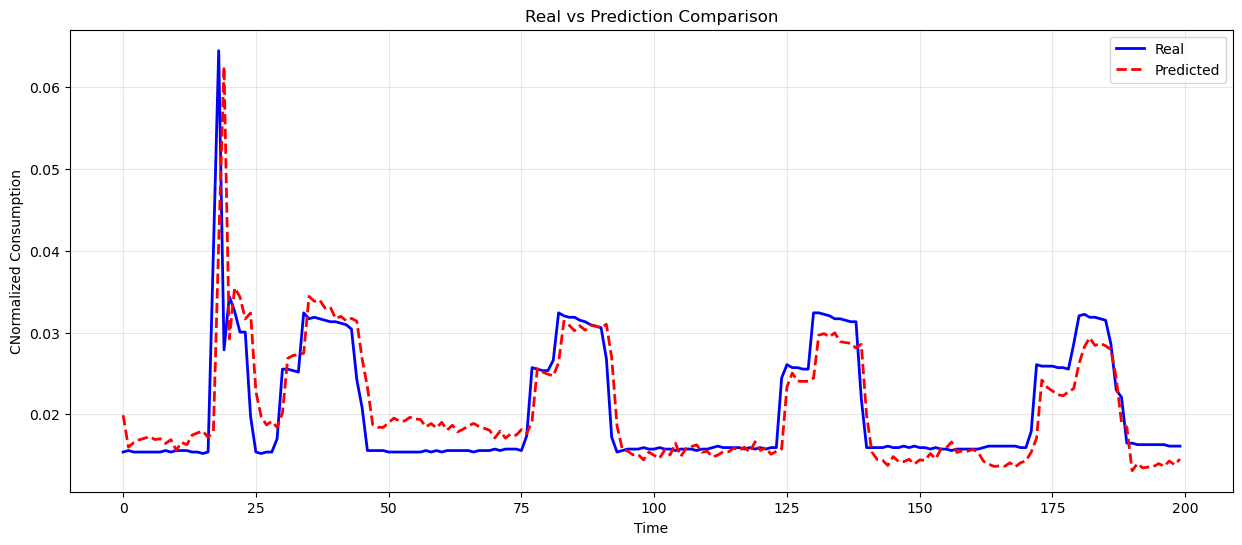

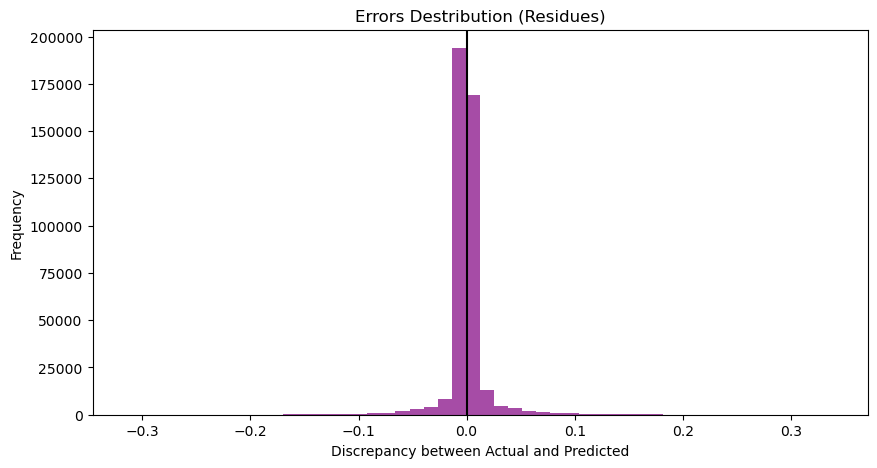

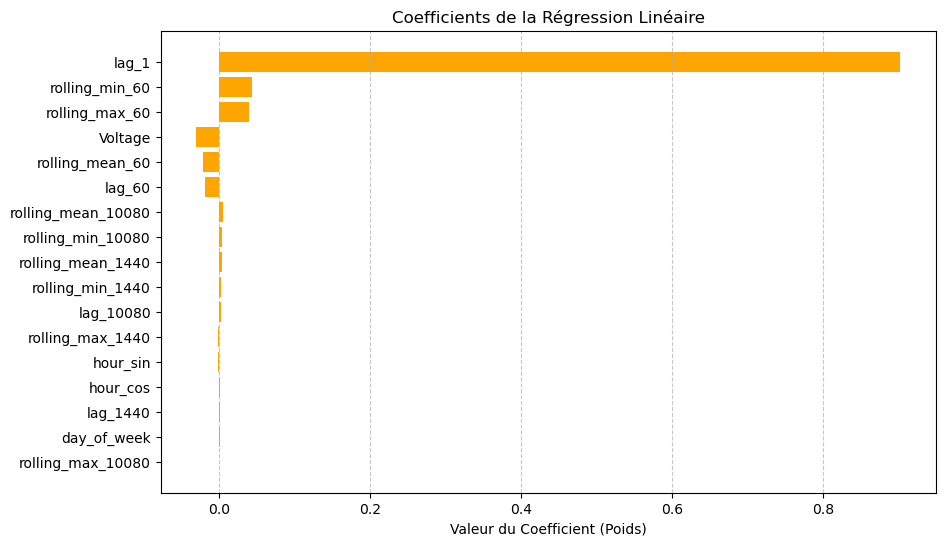


==================== Ridge (Linaire +) ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0083
MSE                  : 0.0004
RMSE (Root of the squared error) : 0.0195
R² Score (Precision) : 0.9403 (94.03%)


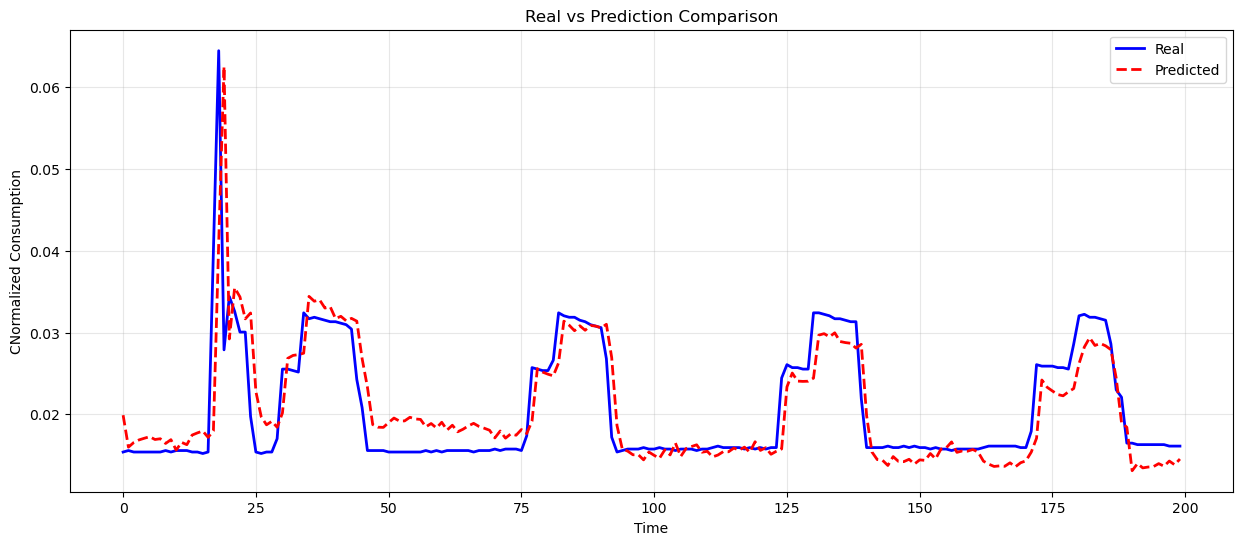

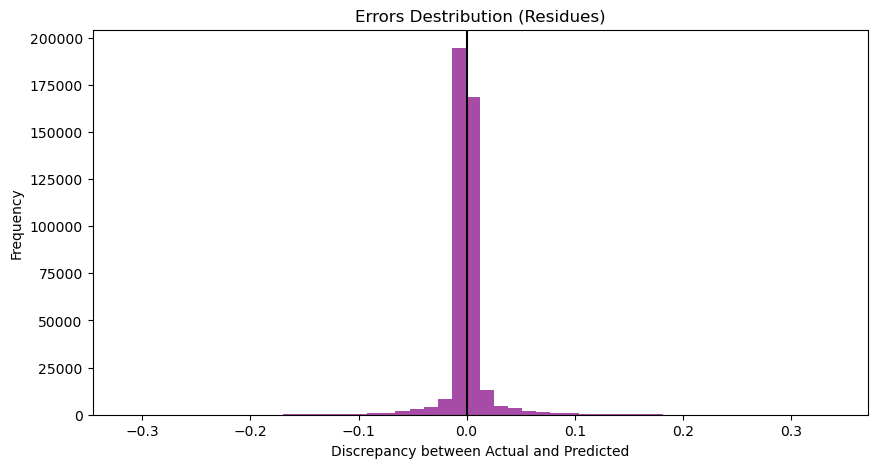

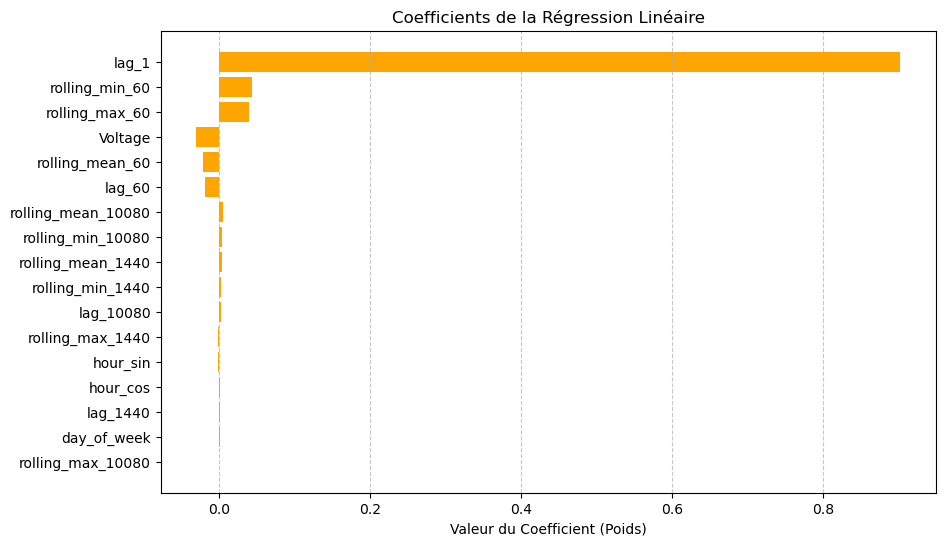


==================== Random Forest ====================


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb 
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet, BayesianRidge, TweedieRegressor
from sklearn.inspection import permutation_importance

base_estimators = [
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('cat', CatBoostRegressor(iterations=500, verbose=0, random_seed=42))
]

models = {
    "LinearRegression": LinearRegression(),
    "Ridge (Linaire +)": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0, random_seed=42),
    "k-NN": KNeighborsRegressor(n_neighbors=7, weights='distance'),
    "SVR": SVR(kernel='rbf', C=1.0),
    "Voting Regressor": VotingRegressor(estimators=base_estimators),
    "Stacking Regressor": StackingRegressor(estimators=base_estimators, final_estimator=Ridge()),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=100),    
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, n_jobs=-1),
    "Bayesian Ridge": BayesianRidge()
}


results = {}

for name, model in models.items():
    print(f'\n' + '='*20 + f' {name} ' + '='*20)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics & Basics Graphics 
    metrics(y_test, preds)
    plot_predictions(y_test, preds)
    plot_residuals(y_test, preds)
    
    if name in ["LinearRegression", "Ridge (Linaire +)"]:
        plot_lr_weights(model, X_train)
        
    elif hasattr(model, 'feature_importances_'):
        plot_feature_importance(model, X_train)
        
    elif name == "CatBoost":
        plot_feature_importance(model, X_train)

    elif name is "Bayesian Ridge":
        weights = pd.Series(model.coef_, index=X_train.columns).sort_values()
        weights.plot(kind='barh', color='skyblue')
        plt.title(f"Coefficients (Variables Weight) : {name}")
        plt.xlabel("Importance / Value")
        plt.tight_layout()
        plt.show()
        
    elif name == "HistGradientBoosting":
        result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
        importances = pd.Series(result.importances_mean, index=X_train.columns).sort_values()
        importances.plot(kind='barh', color='orange')
        plt.title(f"Permutation Importance: {name}")
        plt.xlabel("Importance / Value")
        plt.tight_layout()
        plt.show()
    
    else:
        print(f"INFO : Variables importances doesn't exist for {name}.")

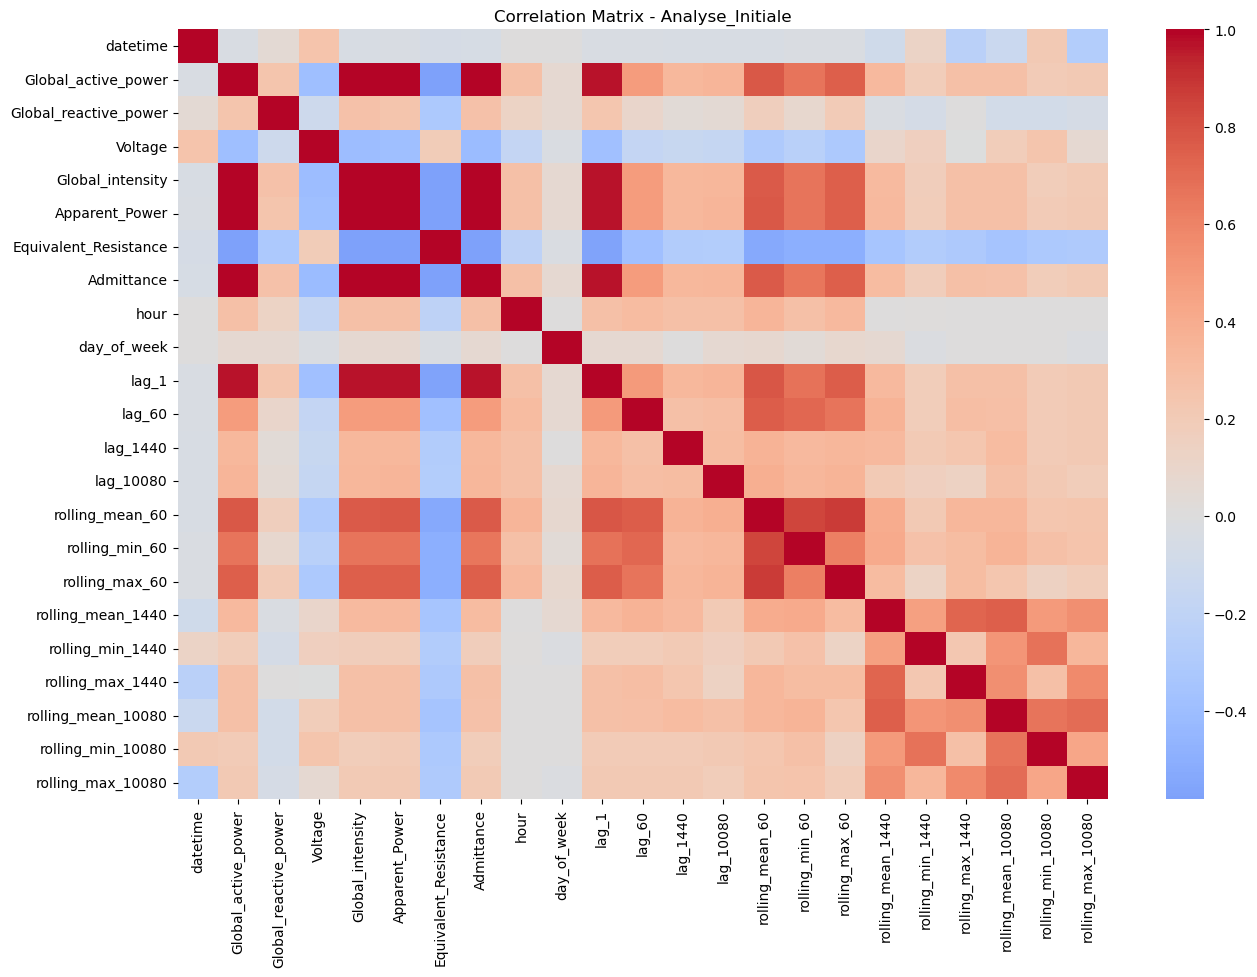

In [130]:
plot_correlation_heatmap(df_extracted, 1, "Analyse_Initiale")

In [131]:
df_reduced = filter_high_correlation(df_extracted, threshold=0.9)
print(f"Nombre de variables avant : {df_extracted.shape[1]}")
print(f"Nombre de variables après : {df_reduced.shape[1]}")

Variables supprimées (car trop corrélées) : ['Global_intensity', 'Apparent_Power', 'Admittance', 'lag_1']
Nombre de variables avant : 23
Nombre de variables après : 19


In [132]:
df_final_scaled, mon_scaler = normalize_features(df_reduced)

In [133]:
X_train, X_test, y_train, y_test = split_data(df_final_scaled, "Global_active_power")

<>:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\User\AppData\Local\Temp\ipykernel_828\1111376669.py:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif name is "Bayesian Ridge":



==================== LinearRegression ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0295
MSE                  : 0.0019
RMSE (Root of the squared error) : 0.0441
R² Score (Precision) : 0.6949 (69.49%)


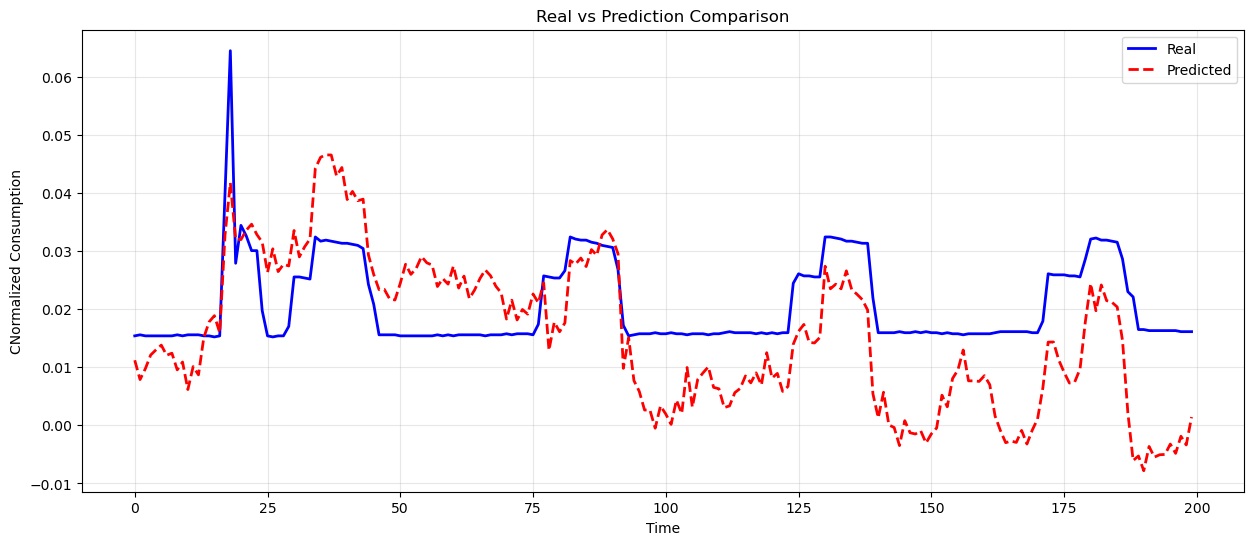

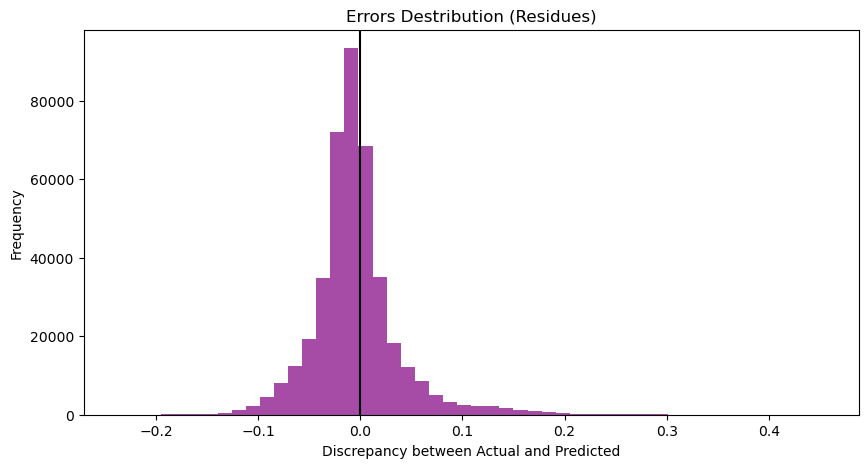

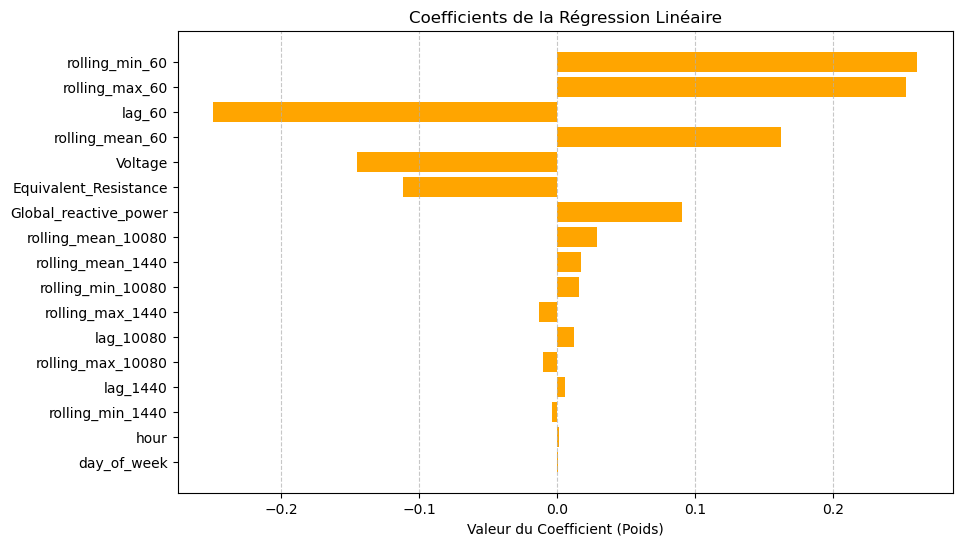


==================== Ridge (Linaire +) ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0295
MSE                  : 0.0019
RMSE (Root of the squared error) : 0.0441
R² Score (Precision) : 0.6949 (69.49%)


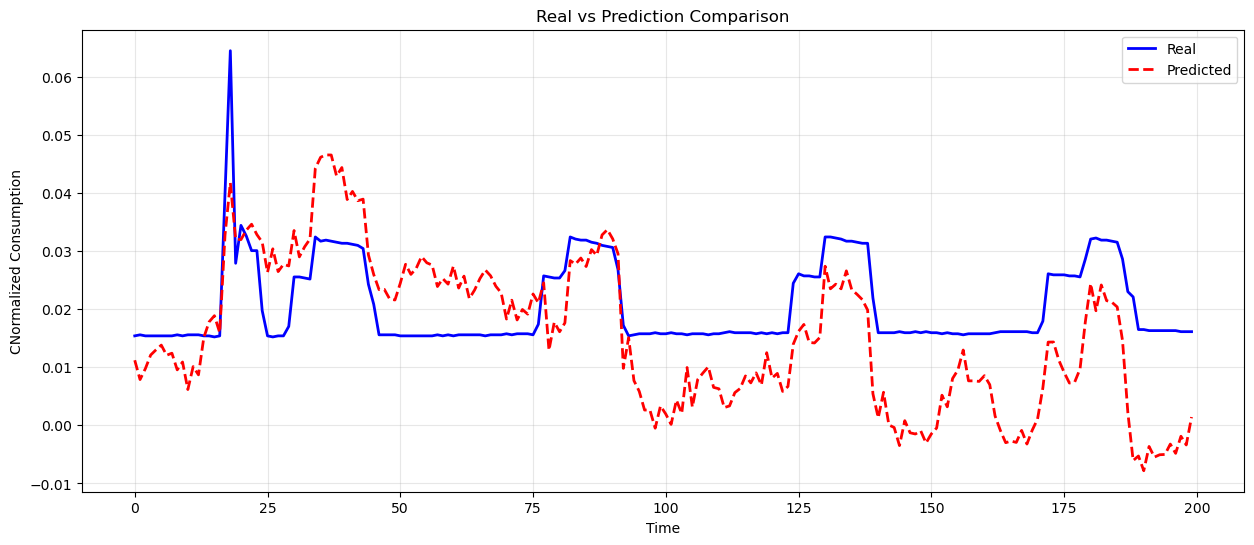

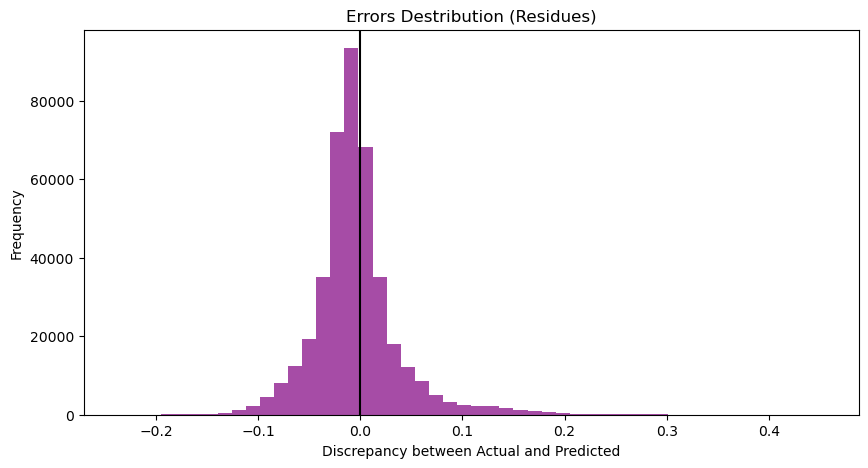

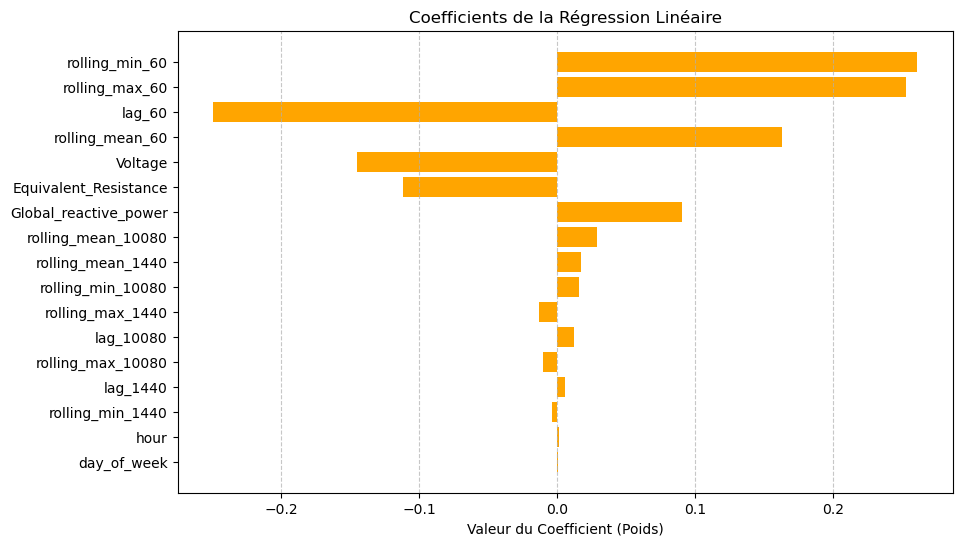


==================== XGBoost ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0020
MSE                  : 0.0000
RMSE (Root of the squared error) : 0.0040
R² Score (Precision) : 0.9975 (99.75%)


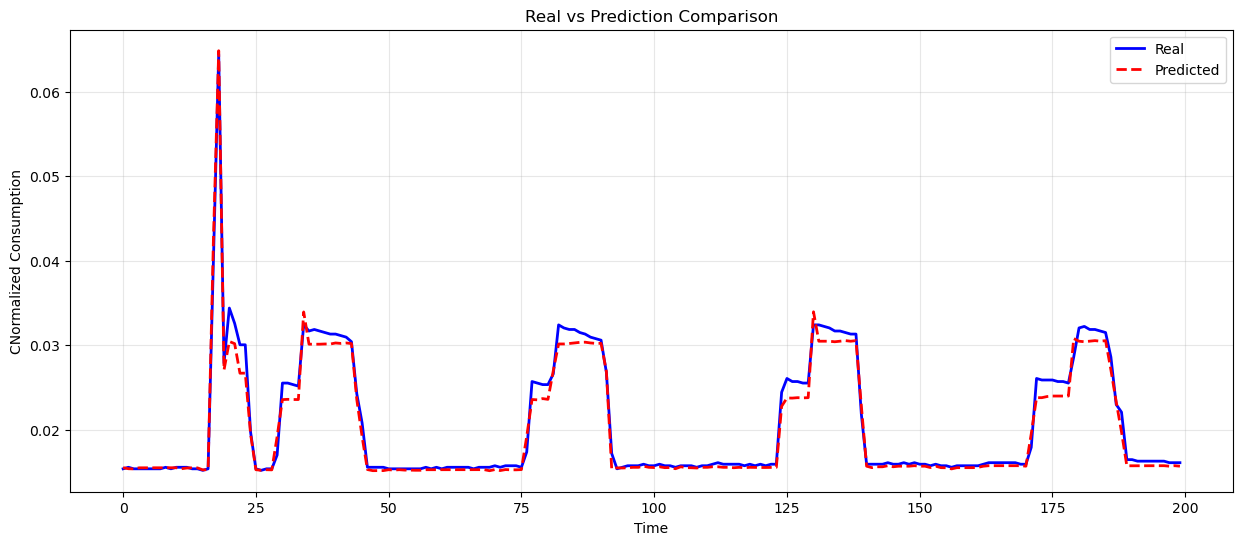

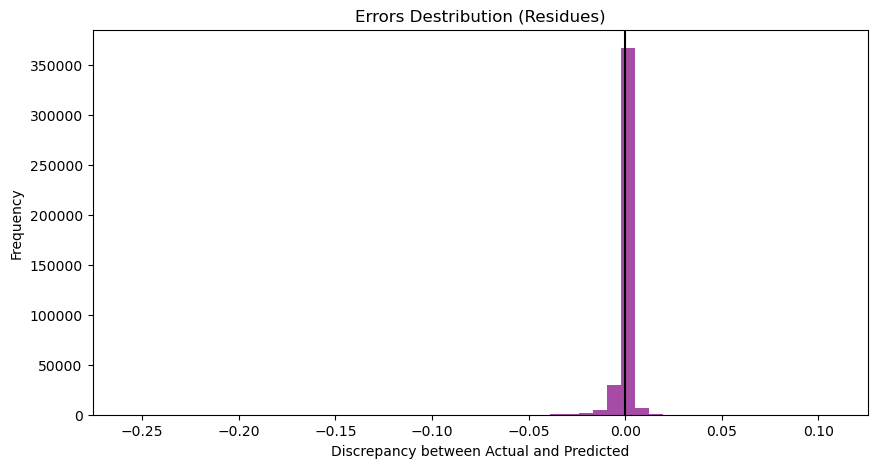

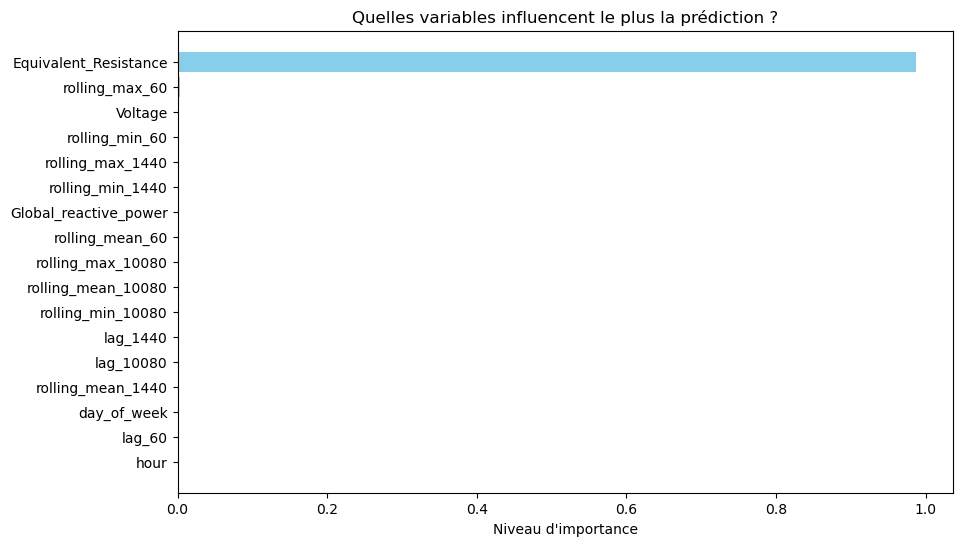


==================== LightGBM ====================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3627
[LightGBM] [Info] Number of data points in the train set: 1652143, number of used features: 17
[LightGBM] [Info] Start training from score 0.093364
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0020
MSE                  : 0.0000
RMSE (Root of the squared error) : 0.0042
R² Score (Precision) : 0.9972 (99.72%)


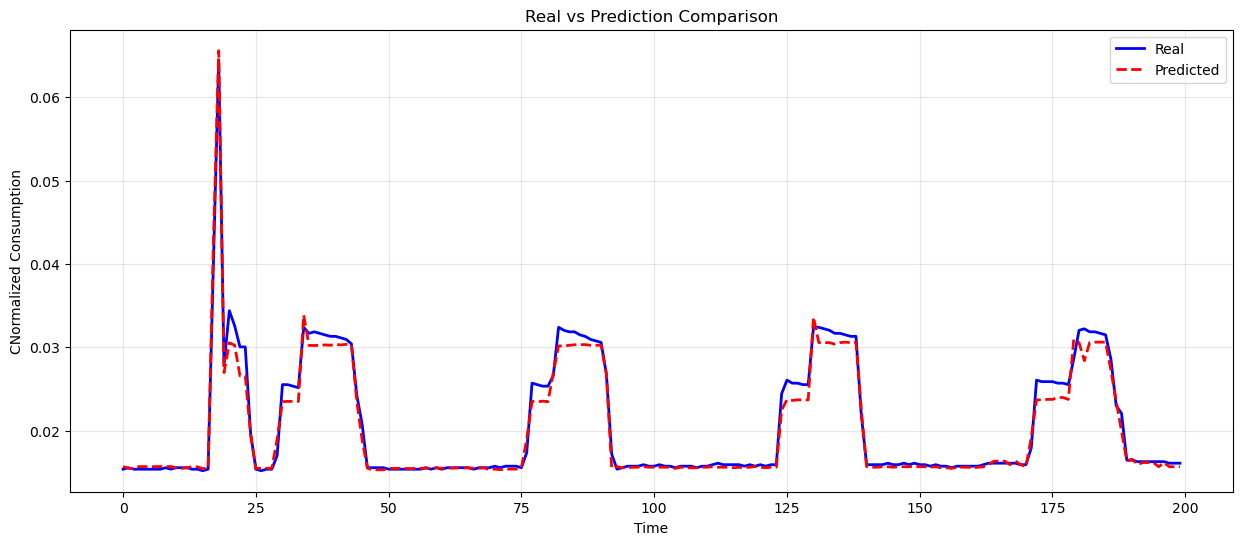

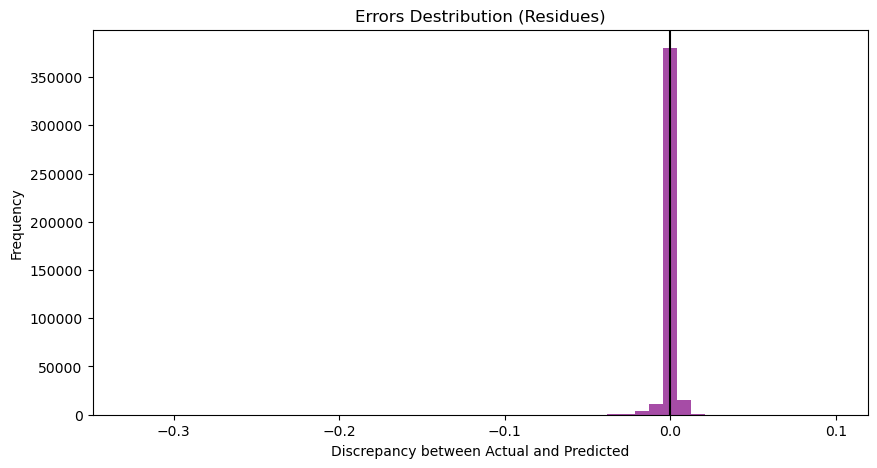

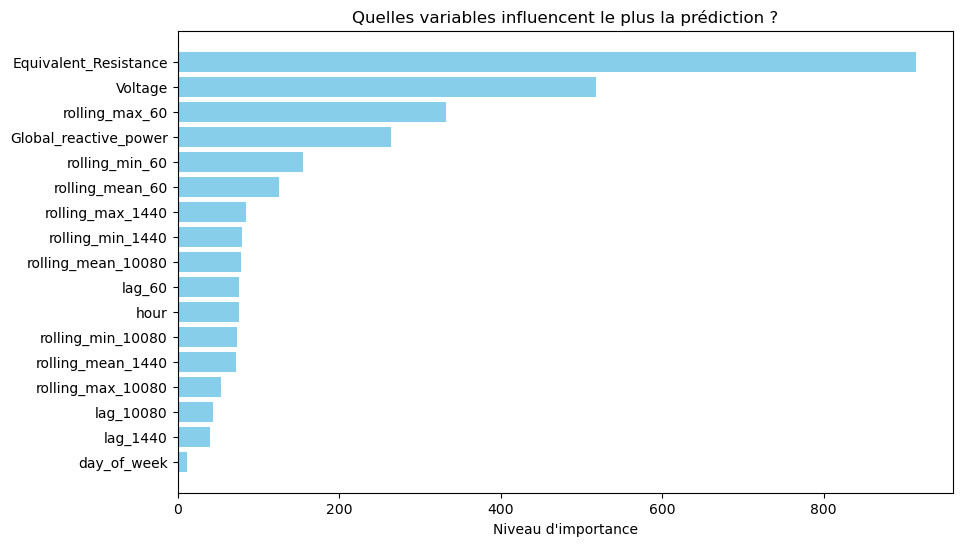


==================== CatBoost ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0019
MSE                  : 0.0000
RMSE (Root of the squared error) : 0.0043
R² Score (Precision) : 0.9971 (99.71%)


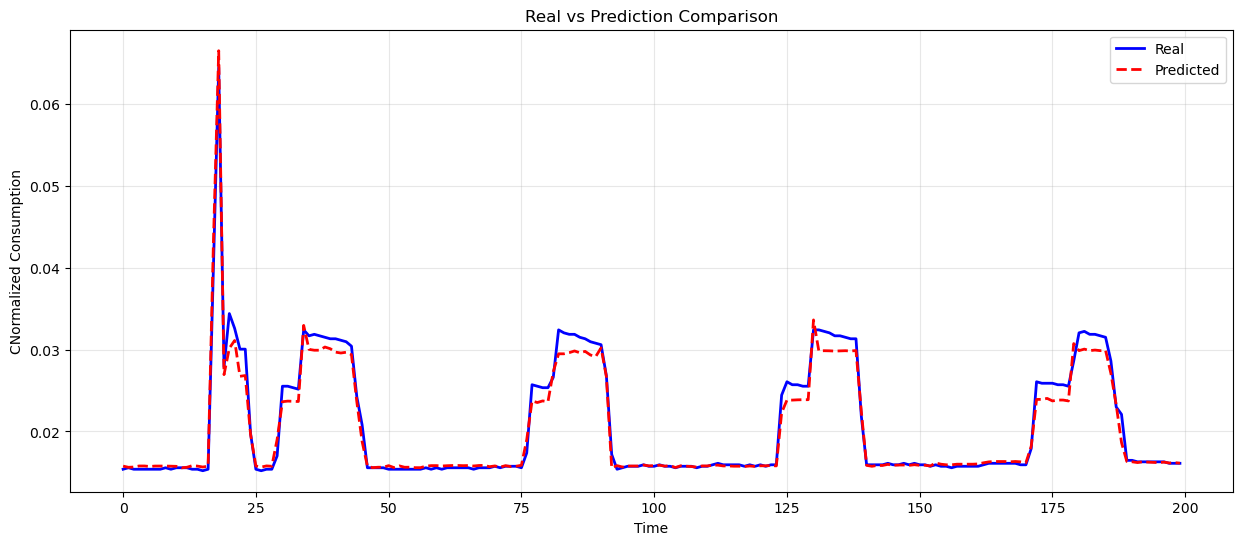

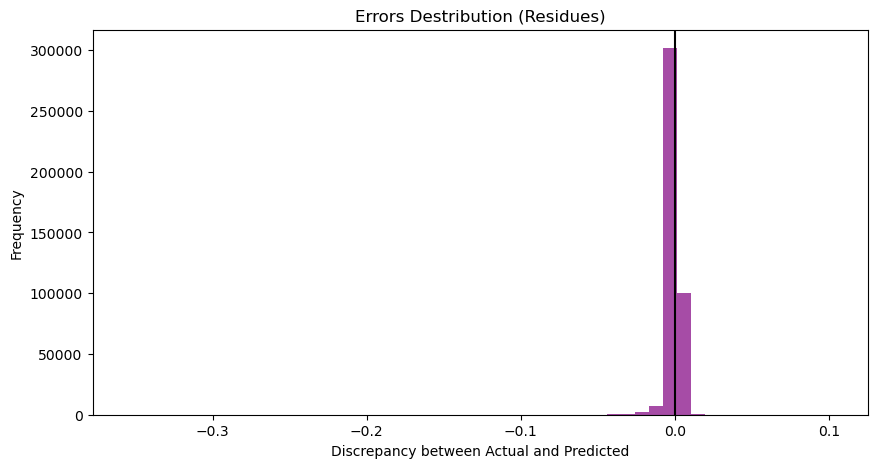

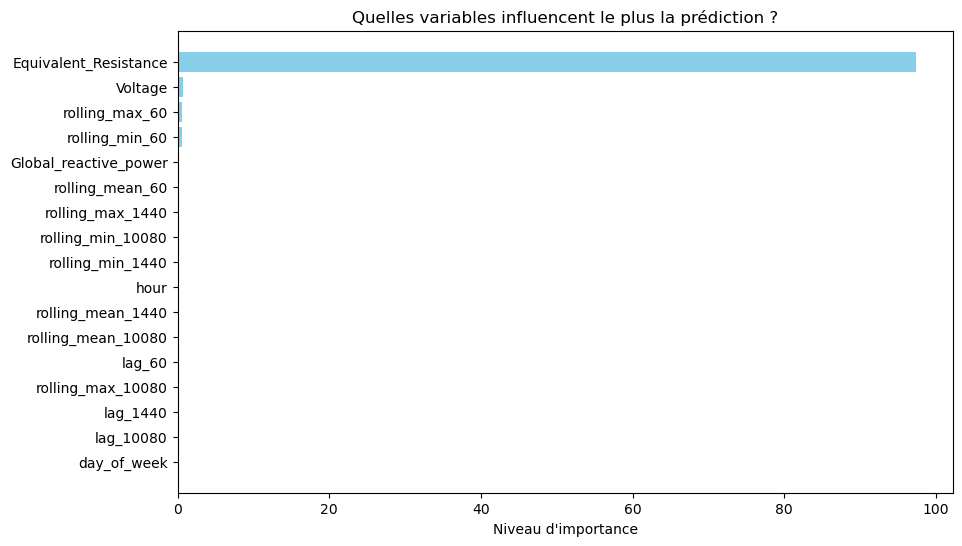


==================== SVR ====================


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb 
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet, BayesianRidge, TweedieRegressor
from sklearn.inspection import permutation_importance

base_estimators = [
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('cat', CatBoostRegressor(iterations=500, verbose=0, random_seed=42))
]

models = {
    "LinearRegression": LinearRegression(),
    "Ridge (Linaire +)": Ridge(alpha=1.0),
    #Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0, random_seed=42),
    #k-NN": KNeighborsRegressor(n_neighbors=7, weights='distance'),
    "SVR": SVR(kernel='rbf', C=1.0),
    "Voting Regressor": VotingRegressor(estimators=base_estimators),
    "Stacking Regressor": StackingRegressor(estimators=base_estimators, final_estimator=Ridge()),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=100),    
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, n_jobs=-1),
    "Bayesian Ridge": BayesianRidge()
}


results = {}

for name, model in models.items():
    print(f'\n' + '='*20 + f' {name} ' + '='*20)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics & Basics Graphics 
    metrics(y_test, preds)
    plot_predictions(y_test, preds)
    plot_residuals(y_test, preds)
    
    if name in ["LinearRegression", "Ridge (Linaire +)"]:
        plot_lr_weights(model, X_train)
        
    elif hasattr(model, 'feature_importances_'):
        plot_feature_importance(model, X_train)
        
    elif name == "CatBoost":
        plot_feature_importance(model, X_train)

    elif name is "Bayesian Ridge":
        weights = pd.Series(model.coef_, index=X_train.columns).sort_values()
        weights.plot(kind='barh', color='skyblue')
        plt.title(f"Coefficients (Variables Weight) : {name}")
        plt.xlabel("Importance / Value")
        plt.tight_layout()
        plt.show()
        
    elif name == "HistGradientBoosting":
        result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
        importances = pd.Series(result.importances_mean, index=X_train.columns).sort_values()
        importances.plot(kind='barh', color='orange')
        plt.title(f"Permutation Importance: {name}")
        plt.xlabel("Importance / Value")
        plt.tight_layout()
        plt.show()
    
    else:
        print(f"INFO : Variables importances doesn't exist for {name}.")

In [ ]:
plot_correlation_heatmap(df_extracted, 1, "Analyse_Initiale")